In [15]:
import matplotlib.pyplot as plt
import pandas as pd
import re

import matplotlib.pyplot as plt
import seaborn as sns

df =pd.read_csv('../../data/options_additions_removals.csv')
df['removed'] = df['commit_date_removed'].notna()
df = df[df['removed']]

ownership
False    7348
True     3064
Name: count, dtype: int64


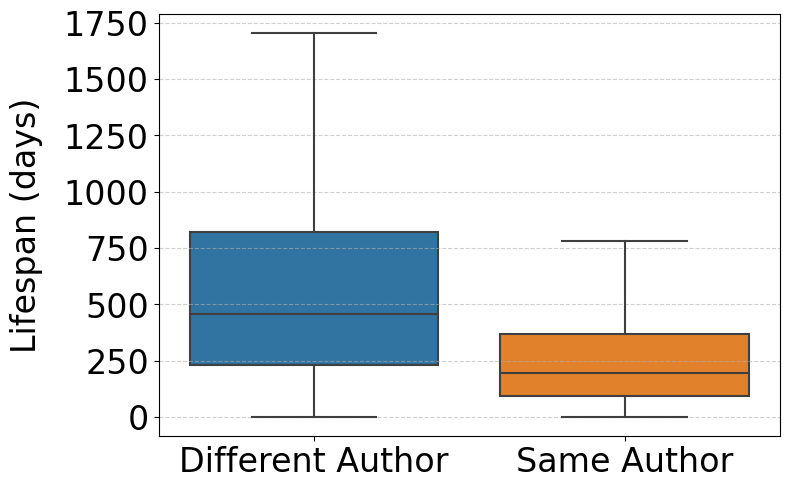

In [48]:

# Function to extract email from commit message
def extract_email(commit_msg):
    match = re.search(r'<(.*?)>', str(commit_msg))
    return match.group(1) if match else None

# Extract emails
df['email_added'] = df['commit_message_added'].apply(extract_email)
df['email_removed'] = df['commit_message_removed'].apply(extract_email)

# Determine ownership
df['ownership'] = df['email_added'] == df['email_removed']

# Show a preview of the relevant columns
print(df['ownership'].value_counts())

# Plot lifespan vs ownership
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='ownership', y='lifecycle_days', showfliers=False)
plt.title('')
plt.xlabel('')
plt.ylabel('Lifespan (days)', fontsize=24, labelpad=15)
plt.xticks([0, 1], ['Different Author', 'Same Author'])  
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.savefig('Fig-OwnershipLifespan.pdf', format='pdf', bbox_inches='tight')
plt.show()




/var/folders/jk/m520gmtj3bb3wx6g5vj9bffw0000gp/T/ipykernel_45461/1611494191.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df['removal_month'] = df['commit_date_removed'].dt.to_period('M').dt.to_timestamp()


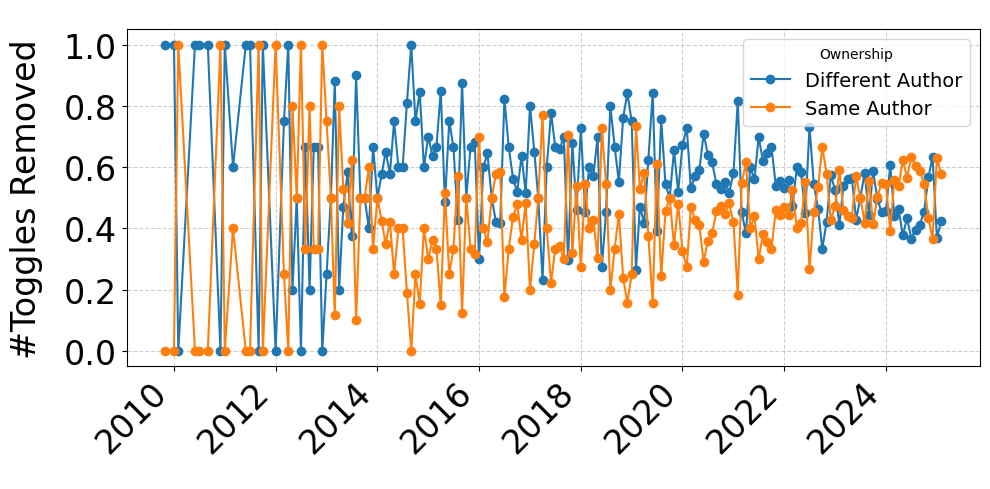

In [ ]:

# Convert removal date to datetime and extract year-month
df['commit_date_removed'] = pd.to_datetime(df['commit_date_removed'], errors='coerce', utc=True)
df['removal_month'] = df['commit_date_removed'].dt.to_period('M').dt.to_timestamp()

# Group by month and ownership
monthly_counts = df.groupby(['removal_month', 'ownership']).size().reset_index(name='count')

# Pivot so we get columns for True/False
pivoted = monthly_counts.pivot(index='removal_month', columns='ownership', values='count').fillna(0)
pivoted.columns = ['Different Author', 'Same Author']  # False = Different, True = Same
#normalized = pivoted.div(pivoted.sum(axis=1), axis=0)

# Plot
plt.figure(figsize=(10, 5))
pivoted.plot(kind='line', marker='o', ax=plt.gca())
plt.title(' ')
plt.xlabel(' ')
plt.ylabel('#Toggles Removed', fontsize=24, labelpad=15)
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(rotation=45, fontsize=24)
plt.yticks(fontsize=24)
plt.legend(title='Ownership', fontsize=14)
plt.tight_layout()
plt.savefig('Fig-EvolutionTogglesByOwnership.pdf', format='pdf', bbox_inches='tight')
plt.show()



In [38]:
# print(df.head())
print(df[(df['removed'] == True) & (df['ownership'] == True)]['lifecycle_days'].describe())

count    3064.000000
mean      280.900783
std       290.287456
min         0.000000
25%        95.000000
50%       196.000000
75%       370.000000
max      2642.000000
Name: lifecycle_days, dtype: float64


In [19]:
import pandas as pd
from datetime import timedelta
import re

# Load all commits
commits = pd.read_csv('../../data/commits_authors.txt', names=['commit_id', 'author_email', 'commit_date'])
commits['commit_date'] = pd.to_datetime(commits['commit_date'])

# Load your toggles data
df = pd.read_csv('../../data/options_additions_removals.csv')

# Extract emails from commit messages
def extract_email(text):
    match = re.search(r'<(.*?)>', str(text))
    return match.group(1) if match else None

df['email_added'] = df['commit_message_added'].apply(extract_email)
df['email_removed'] = df['commit_message_removed'].apply(extract_email)
df['ownership'] = df['email_added'] == df['email_removed']
df['removed'] = df['commit_date_removed'].notna()
df['commit_date_removed'] = pd.to_datetime(df['commit_date_removed'], errors='coerce', utc=True)

# Focus on toggles removed by someone else
df_diff_owner = df[(df['removed']) & (df['ownership'] == False)].copy()

# Function to check activity window
def check_activity(row, window_days=30):
    adder = row['email_added']
    removal_date = row['commit_date_removed']
    start = removal_date - timedelta(days=window_days)
    end = removal_date + timedelta(days=window_days)
    
    count = commits[
        (commits['author_email'] == adder) &
        (commits['commit_date'] >= start) &
        (commits['commit_date'] <= end)
    ].shape[0]
    
    return count

# Apply to each row
df_diff_owner['active_near_removal'] = df_diff_owner.apply(check_activity, axis=1)

# Show results
print(df_diff_owner[['variable', 'email_added', 'email_removed', 'commit_date_removed', 'active_near_removal']].head())

# Optional: count stats
activity_counts = df_diff_owner['active_near_removal'].value_counts()
print("\nAuthor activity around toggle removal (±30 days):")
print(activity_counts)


                             variable             email_added  \
8                   AOMAriaProperties     rakina@chromium.org   
11                          AOMPhase1  meredithl@chromium.org   
18  AccessibilityAriaTouchPassthrough   dmazzoni@chromium.org   
21     AccessibilityEagerAXTreeUpdate   chrishtr@chromium.org   
24     AccessibilityExposeHTMLElement   dmazzoni@chromium.org   

            email_removed       commit_date_removed  active_near_removal  
8         rego@igalia.com 2022-04-15 12:02:10+00:00                   14  
11    rakina@chromium.org 2019-10-25 04:08:32+00:00                   20  
18  mschillaci@google.com 2023-06-01 18:07:44+00:00                    0  
21  aleventhal@google.com 2023-10-27 00:12:14+00:00                   10  
24  mschillaci@google.com 2024-04-01 16:06:17+00:00                    0  

Author activity around toggle removal (±30 days):
active_near_removal
0      1278
1       160
3       103
2       101
4        89
       ... 
205       1
138 

In [20]:
import pandas as pd
from datetime import timedelta
import re

# Load all commits
commits = pd.read_csv('../../data/commits_authors.txt', names=['commit_id', 'author_email', 'commit_date'])
commits['commit_date'] = pd.to_datetime(commits['commit_date'])

# Load toggles data
df = pd.read_csv('../../data/options_additions_removals.csv')

# Extract emails from commit messages
def extract_email(text):
    match = re.search(r'<(.*?)>', str(text))
    return match.group(1) if match else None

df['email_added'] = df['commit_message_added'].apply(extract_email)
df['email_removed'] = df['commit_message_removed'].apply(extract_email)
df['ownership'] = df['email_added'] == df['email_removed']
df['removed'] = df['commit_date_removed'].notna()
df['commit_date_removed'] = pd.to_datetime(df['commit_date_removed'], errors='coerce', utc=True)
df['commit_date_added'] = pd.to_datetime(df['commit_date_added'], errors='coerce', utc=True)

# Focus on toggles removed by someone else
df_diff_owner = df[(df['removed']) & (df['ownership'] == False)].copy()

# Generalized function to count commits around a date for an author
def count_commits_around(date, author, window_days=30):
    if pd.isnull(date) or pd.isnull(author):
        return 0
    start = date - timedelta(days=window_days)
    end = date + timedelta(days=window_days)
    return commits[
        (commits['author_email'] == author) &
        (commits['commit_date'] >= start) &
        (commits['commit_date'] <= end)
    ].shape[0]

# Apply for all relevant periods
df_diff_owner['adder_commits_near_addition'] = df_diff_owner.apply(
    lambda row: count_commits_around(row['commit_date_added'], row['email_added']), axis=1
)

df_diff_owner['adder_commits_near_removal'] = df_diff_owner.apply(
    lambda row: count_commits_around(row['commit_date_removed'], row['email_added']), axis=1
)

df_diff_owner['remover_commits_near_removal'] = df_diff_owner.apply(
    lambda row: count_commits_around(row['commit_date_removed'], row['email_removed']), axis=1
)

# Show results
print(df_diff_owner[['variable', 'email_added', 'email_removed',
                     'commit_date_added', 'commit_date_removed',
                     'adder_commits_near_addition',
                     'adder_commits_near_removal',
                     'remover_commits_near_removal']].head())

# Optional summary
print("\nSummary stats:")
print("Adder activity near addition:")
print(df_diff_owner['adder_commits_near_addition'].describe())

print("\nAdder activity near removal:")
print(df_diff_owner['adder_commits_near_removal'].describe())

print("\nRemover activity near removal:")
print(df_diff_owner['remover_commits_near_removal'].describe())


                             variable             email_added  \
8                   AOMAriaProperties     rakina@chromium.org   
11                          AOMPhase1  meredithl@chromium.org   
18  AccessibilityAriaTouchPassthrough   dmazzoni@chromium.org   
21     AccessibilityEagerAXTreeUpdate   chrishtr@chromium.org   
24     AccessibilityExposeHTMLElement   dmazzoni@chromium.org   

            email_removed         commit_date_added       commit_date_removed  \
8         rego@igalia.com 2019-10-25 04:08:32+00:00 2022-04-15 12:02:10+00:00   
11    rakina@chromium.org 2019-08-28 06:33:47+00:00 2019-10-25 04:08:32+00:00   
18  mschillaci@google.com 2021-05-20 00:26:10+00:00 2023-06-01 18:07:44+00:00   
21  aleventhal@google.com 2023-05-15 22:19:08+00:00 2023-10-27 00:12:14+00:00   
24  mschillaci@google.com 2020-03-21 03:38:22+00:00 2024-04-01 16:06:17+00:00   

    adder_commits_near_addition  adder_commits_near_removal  \
8                            16                          14

In [21]:
print(len(df_diff_owner[df_diff_owner['adder_commits_near_removal']<=0])/len(df_diff_owner))
print(df_diff_owner['adder_commits_near_removal'].median())
print(df_diff_owner['adder_commits_near_addition'].median())
print(df_diff_owner['remover_commits_near_removal'].median())
df_diff_owner['ratio'] = df_diff_owner['adder_commits_near_addition']/df_diff_owner['adder_commits_near_removal']

print(df_diff_owner['ratio'].median())

print(len(df_diff_owner))

0.34308724832214765
6.0
17.0
24.0
2.3636363636363638
3725


In [40]:
df_rm = df[df['removed']==True]
# Drop missing values and get clean sets
all_adders = df_rm['email_added'].dropna()
all_removers = df_rm['email_removed'].dropna()

unique_adders = set(all_adders)
unique_removers = set(all_removers)

# 1. Adders who never removed
only_adders = unique_adders - unique_removers
num_only_adders = len(only_adders)

# 2. Removers who never added
only_removers = unique_removers - unique_adders
num_only_removers = len(only_removers)

# 3. Developers who did both
both_roles = unique_adders & unique_removers
num_both_roles = len(both_roles)

# 4. Total unique devs involved in toggles
all_toggle_devs = unique_adders | unique_removers
total_unique_devs = len(all_toggle_devs)

# 5. High-volume removers (e.g., more than 5 removals)
removal_counts = all_removers.value_counts()
high_volume_removers = removal_counts[removal_counts >= 10]
num_high_volume_removers = len(high_volume_removers)

# ==== Summary Report ====

print(f"📊 Toggle Developer Role Summary\n{'-'*40}")
print(f"👨‍💻 Total unique developers who added toggles:     {len(unique_adders)}")
print(f"🧹 Total unique developers who removed toggles:   {len(unique_removers)}")
print(f"🔄 Developers who did both add & remove toggles:  {num_both_roles}")
print(f"➕ Developers who ONLY added toggles:             {num_only_adders} "
      f"({num_only_adders / total_unique_devs:.1%} of all)")
print(f"➖ Developers who ONLY removed toggles:           {num_only_removers} "
      f"({num_only_removers / total_unique_devs:.1%} of all)")
print(f"💪 Developers who removed >=10 toggles:           {num_high_volume_removers}")
print(f"👥 Total unique toggle-related developers:        {total_unique_devs}")


📊 Toggle Developer Role Summary
----------------------------------------
👨‍💻 Total unique developers who added toggles:     1856
🧹 Total unique developers who removed toggles:   1491
🔄 Developers who did both add & remove toggles:  1175
➕ Developers who ONLY added toggles:             681 (31.4% of all)
➖ Developers who ONLY removed toggles:           316 (14.5% of all)
💪 Developers who removed >=10 toggles:           143
👥 Total unique toggle-related developers:        2172


📊 Median toggle lifespan (days):
Removed by 💪 devs: 338.0
Removed by others: 285.5

📉 Mann-Whitney U test: p-value = 0.0000


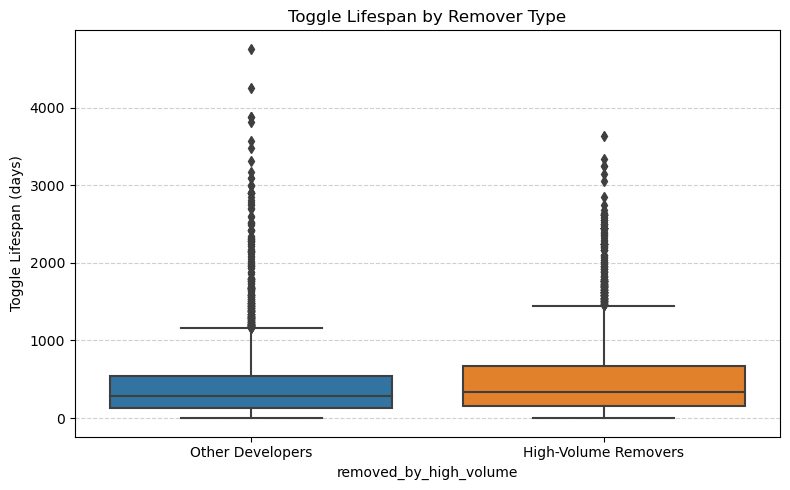

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu

# Assumes df is already loaded and includes 'email_removed', 'lifecycle_days', etc.

# 1. Count toggle removals per developer
removal_counts = df['email_removed'].value_counts()

# 2. Identify high-volume removers (≥10)
high_volume_removers = removal_counts[removal_counts >= 10].index

# 3. Filter to only removed toggles
df_removed = df[df['removed']].copy()

# 4. Tag toggles based on who removed them
df_removed['removed_by_high_volume'] = df_removed['email_removed'].isin(high_volume_removers)

# 5. Compare lifespans
lifespans_high = df_removed[df_removed['removed_by_high_volume']]['lifecycle_days']
lifespans_others = df_removed[~df_removed['removed_by_high_volume']]['lifecycle_days']

# 6. Summary stats
print("📊 Median toggle lifespan (days):")
print(f"Removed by 💪 devs: {lifespans_high.median():.1f}")
print(f"Removed by others: {lifespans_others.median():.1f}")

# 7. Mann-Whitney U test (non-parametric)
stat, p = mannwhitneyu(lifespans_high, lifespans_others, alternative='two-sided')
print(f"\n📉 Mann-Whitney U test: p-value = {p:.4f}")

# 8. Boxplot visualization
plt.figure(figsize=(8, 5))
sns.boxplot(x='removed_by_high_volume', y='lifecycle_days', data=df_removed)
plt.xticks([0, 1], ['Other Developers', 'High-Volume Removers'])
plt.ylabel('Toggle Lifespan (days)')
plt.title('Toggle Lifespan by Remover Type')
plt.grid(True, axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [47]:
high_removers_data=df_removed[df_removed['removed_by_high_volume']]
print(len(df_removed))
print(len(high_removers_data))

print(high_removers_data['ownership'].value_counts())

6789
3269
ownership
False    1839
True     1430
Name: count, dtype: int64
